In [1]:
# !pip -q install transformers==4.20.1

In [5]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lib_file import lib_path
import seaborn as sns
from tqdm.notebook import tqdm

import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import set_seed, TrainingArguments, Trainer, GPT2Config, GPT2Tokenizer
from transformers import get_linear_schedule_with_warmup, GPT2ForSequenceClassification

In [6]:
df = pd.read_csv("cleaned_data.csv")

In [7]:
df.shape

(10000, 2)

In [8]:
df.head()

,cleaned_text,sentiment
0,that is awsome you might know jay awada,Positive
1,quotohh o stop biting me ohhh the humanity o ...,Positive
2,in bed now alone lol,Negative
3,time to sleep nyt socal see yah in 3 weekshav...,Positive
4,true luxury has evolved into something called ...,Positive


In [9]:
df.columns.tolist()

['cleaned_text', 'sentiment']

---

In [10]:
max_len = 50
batch_size = 32
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
class DatasetCreater(Dataset):
    def __init__(self, processed_data, train):
        self.data = processed_data
        self.train = train
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        line = self.data.iloc[index]
        if self.train:
            return {"text":line["cleaned_text"], "label":line["sentiment"]}
        else:
            return {"text":line["cleaned_text"], "label":0}

In [12]:
class GPT2_collator(object):
    def __init__(self, tokenizer, max_seq_len=None):
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        return
    def __call__(self,sequences):
        texts = [sequence['text'] for sequence in sequences]
        labels = [int(sequence['label']) for sequence in sequences]
        inputs = self.tokenizer(text=texts,
                               return_tensors="pt",
                               padding=True,
                               truncation=True,
                               max_length=self.max_seq_len)
        inputs.update({"labels":torch.tensor(labels)})
        return inputs

In [13]:
def train(dataloader, optimizer, scheduler, device):
    global model
    model.train()
    predictions_labels = []
    true_labels = []
    total_loss = 0
    for batch in tqdm(dataloader, total=len(dataloader)):
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        loss, logits = outputs[:2]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        predictions_labels += logits.argmax(axis=-1).flatten().tolist()
    avg_epoch_loss = total_loss / len(dataloader)
    return predictions_labels, true_labels, avg_epoch_loss

In [14]:
def validate(dataloader, device):
    global model
    model.eval()
    predictions_labels = []
    true_labels = []
    total_loss = 0
    for batch in tqdm(dataloader, total=len(dataloader)):
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            loss, logits = outputs[:2]
            total_loss += loss.item()
            predictions_labels += logits.argmax(axis=-1).flatten().tolist()
    avg_epoch_loss = total_loss / len(dataloader)
    return predictions_labels, true_labels, avg_epoch_loss

In [15]:
print("Loading gpt-2 model...")
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path="gpt2-medium", num_labels=2)
print("Loading tokenizer...")
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path="gpt2-medium")
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
print("Loading model...")
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path="gpt2-medium", config=model_config)
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id
model.to(device)

Loading gpt-2 model...


Downloading:   0%|          | 0.00/718 [00:00<?, ?B/s]

Loading tokenizer...


Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Loading model...


Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2-medium and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=1024, out_features=2, bias=False)
)

In [16]:
gpt2_collator = GPT2_collator(tokenizer=tokenizer, max_seq_len=max_len)

In [17]:
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x=='Positive' else 0)
df.head()

,cleaned_text,sentiment
0,that is awsome you might know jay awada,1
1,quotohh o stop biting me ohhh the humanity o ...,1
2,in bed now alone lol,0
3,time to sleep nyt socal see yah in 3 weekshav...,1
4,true luxury has evolved into something called ...,1


In [18]:
train_data = df.sample(frac=0.8, random_state=0)
train_data.head()

,cleaned_text,sentiment
9394,seek the truth and the truth will set you free...,1
898,finally wrapped my body has literally broken ...,0
2398,really want to see kasabian at eden project 4t...,0
5906,lol that is a very interesting interpretation...,1
2343,i posted my 91 golf up for sale last night and...,0


In [19]:
val_data = df.drop(train_data.index)
val_data.head()

,cleaned_text,sentiment
0,that is awsome you might know jay awada,1
13,the result is tomorrow oh nooooo,0
21,is on bed rest for a few more days docs orders...,0
25,my pinky toe has been broken for months i shou...,1
26,omg yes summer vacation they are so old school,1


In [20]:
print(f"Train data shape : {train_data.shape}")
print(f"Val data shape : {val_data.shape}")

Train data shape : (8000, 2)
Val data shape : (2000, 2)


In [21]:
# Prepare training data
train_data = DatasetCreater(train_data, train=True)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=gpt2_collator)

# Prepare validation data
val_data = DatasetCreater(val_data, train=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True, collate_fn=gpt2_collator)

In [22]:
optimizer = torch.optim.AdamW(model.parameters())
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)
loss = []
accuracy = []
val_loss_list = []
val_accuracy_list = []

for epoch in tqdm(range(epochs)):
    train_labels, true_labels, train_loss = train(train_dataloader, optimizer, scheduler, device)
    train_acc = accuracy_score(true_labels, train_labels)
    print('epoch: %.2f train accuracy %.2f' % (epoch, train_acc))
    loss.append(train_loss)
    accuracy.append(train_acc)

    val_labels, val_true_labels, val_loss = validate(val_dataloader, device)
    val_acc= accuracy_score(val_true_labels, val_labels)
    print('epoch: %.2f validation accuracy %.2f' % (epoch, val_acc))
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_acc)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

epoch: 0.00 train accuracy 0.57


  0%|          | 0/63 [00:00<?, ?it/s]

epoch: 0.00 validation accuracy 0.63


  0%|          | 0/250 [00:00<?, ?it/s]

epoch: 1.00 train accuracy 0.72


  0%|          | 0/63 [00:00<?, ?it/s]

epoch: 1.00 validation accuracy 0.69


  0%|          | 0/250 [00:00<?, ?it/s]

epoch: 2.00 train accuracy 0.79


  0%|          | 0/63 [00:00<?, ?it/s]

epoch: 2.00 validation accuracy 0.68


  0%|          | 0/250 [00:00<?, ?it/s]

epoch: 3.00 train accuracy 0.85


  0%|          | 0/63 [00:00<?, ?it/s]

epoch: 3.00 validation accuracy 0.68


  0%|          | 0/250 [00:00<?, ?it/s]

epoch: 4.00 train accuracy 0.88


  0%|          | 0/63 [00:00<?, ?it/s]

epoch: 4.00 validation accuracy 0.67


  0%|          | 0/250 [00:00<?, ?it/s]

epoch: 5.00 train accuracy 0.90


  0%|          | 0/63 [00:00<?, ?it/s]

epoch: 5.00 validation accuracy 0.66


  0%|          | 0/250 [00:00<?, ?it/s]

epoch: 6.00 train accuracy 0.92


  0%|          | 0/63 [00:00<?, ?it/s]

epoch: 6.00 validation accuracy 0.66


  0%|          | 0/250 [00:00<?, ?it/s]

epoch: 7.00 train accuracy 0.93


  0%|          | 0/63 [00:00<?, ?it/s]

epoch: 7.00 validation accuracy 0.66


  0%|          | 0/250 [00:00<?, ?it/s]

epoch: 8.00 train accuracy 0.94


  0%|          | 0/63 [00:00<?, ?it/s]

epoch: 8.00 validation accuracy 0.66


  0%|          | 0/250 [00:00<?, ?it/s]

epoch: 9.00 train accuracy 0.94


  0%|          | 0/63 [00:00<?, ?it/s]

epoch: 9.00 validation accuracy 0.66


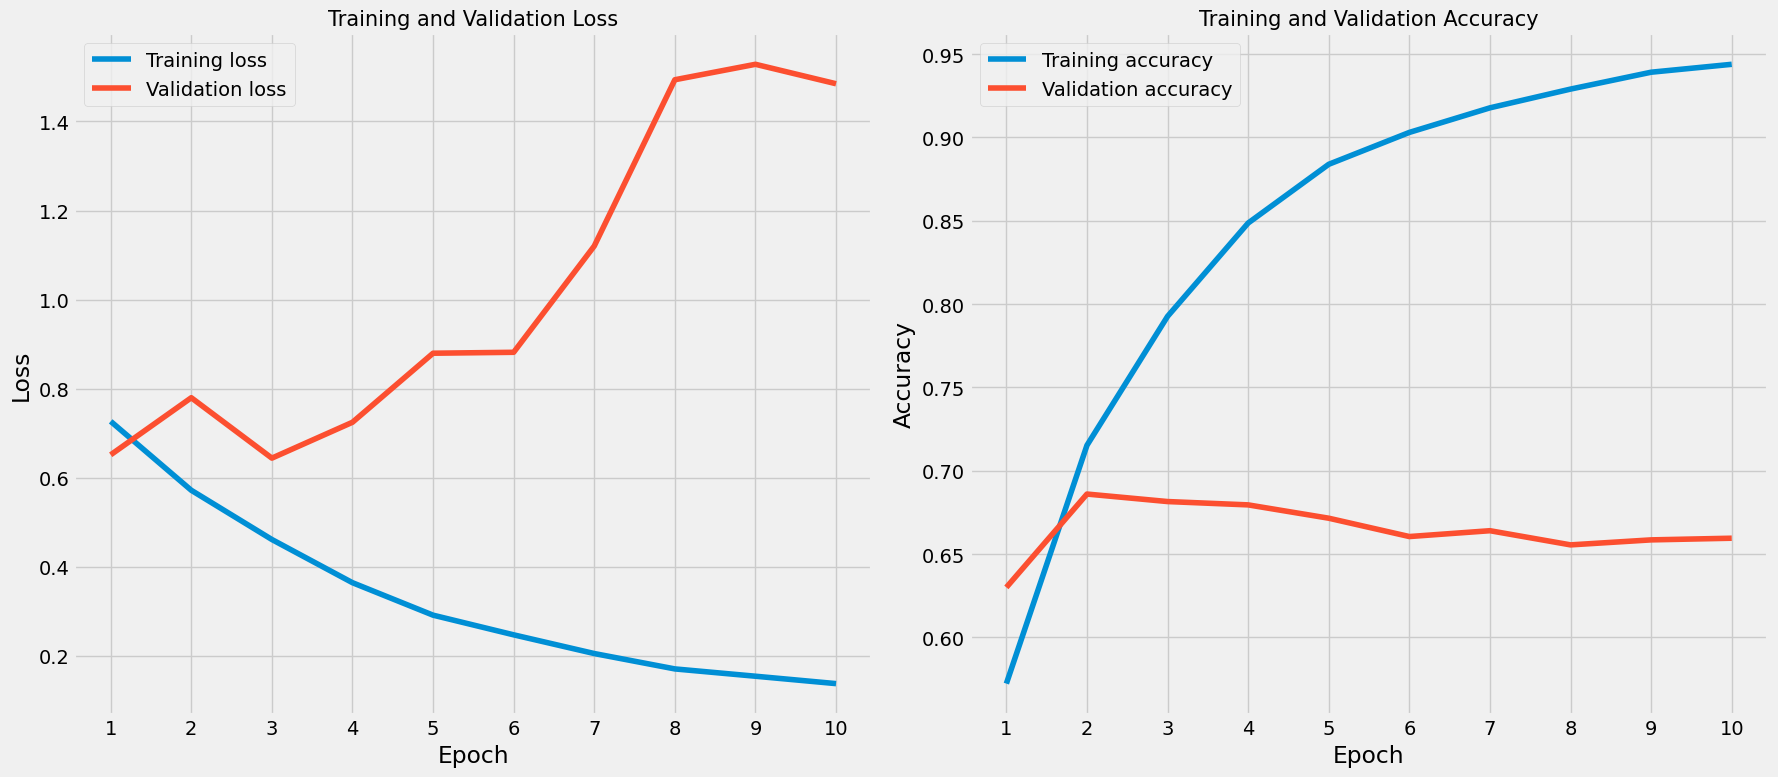

In [23]:
with plt.style.context(style="fivethirtyeight"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    ax1.plot([str(i) for i in range(1,len(loss)+1)], np.array(loss), label='Training loss')
    ax1.plot([str(i) for i in range(1,len(val_loss_list)+1)],np.array(val_loss_list), label='Validation loss')
    ax1.set_title('Training and Validation Loss',fontsize=15)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax2.plot([str(i) for i in range(1,len(accuracy)+1)],np.array(accuracy), label='Training accuracy')
    ax2.plot([str(i) for i in range(1,len(val_accuracy_list)+1)],np.array(val_accuracy_list), label='Validation accuracy')
    ax2.set_title('Training and Validation Accuracy',fontsize=15)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    plt.tight_layout()
    plt.show()

In [24]:
tokenizer_directory = "tokenizer_directory"
model_directory = "model_directory"

tokenizer.save_pretrained(tokenizer_directory)
model.save_pretrained(model_directory)

In [25]:
val_labels, val_true_labels, val_loss = validate(val_dataloader, device)

  0%|          | 0/63 [00:00<?, ?it/s]

# Result Analysis

In [26]:
class_labels = ["negative", "positive"]

***Accuracy Score***

In [27]:
accuracy=accuracy_score(y_true=val_true_labels,y_pred=val_labels)
print(f"Validation accuracy of GPT2 model is {accuracy*100.0:.2f}%")

Validation accuracy of GPT2 model is 65.20%


***Classification Report***

In [28]:
print(classification_report(y_true=val_true_labels,y_pred=val_labels,target_names=class_labels))

              precision    recall  f1-score   support

    negative       0.64      0.68      0.66      1003
    positive       0.66      0.62      0.64       997

    accuracy                           0.65      2000
   macro avg       0.65      0.65      0.65      2000
weighted avg       0.65      0.65      0.65      2000



***Confusion Matrix***

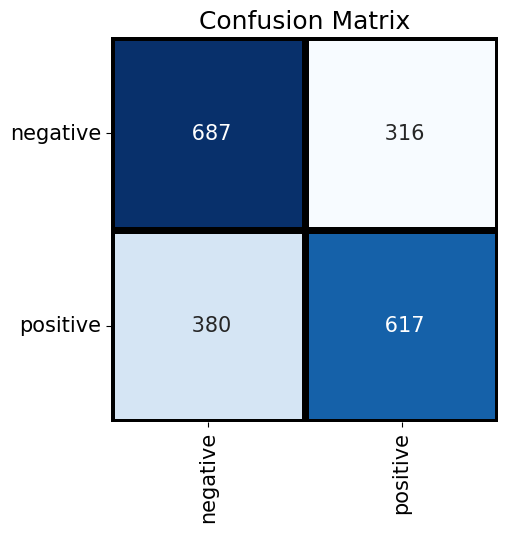

In [29]:
plt.figure(figsize=(5,5))
plt.rcParams['font.size']=15
sns.heatmap(data=confusion_matrix(y_true=val_true_labels,y_pred=val_labels),
            cmap=plt.cm.Blues,
            annot=True,
            fmt='4d',
            cbar=False,
            linecolor='black',
            linewidths=5,
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title(label='Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

---